# IMAGE-CAD-ANSYS Interface (I CAN)

## _Versión 0.1_
### Author: Jorge Cárdenas
### Pontificia Universidad de Valparaíso
This development is intended to provide an interface to access HFSS, in order to automate simulation and optimization processes.

## Features

- Extract features based on HSV color mapping
- Create DXF file to be loaded into HFSS


In [7]:

#%pip install ezdxf
#%pip install imutils
%pip install ipywidgets


  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for comm>=0.1.3 from https://files.pythonhosted.org/packages/7b/a6/5fd0242e974914b139451eea0a61ed9fd2e47157e33a67939043c50a94dd/comm-0.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.9 from https://files.pythonhosted.org/packages/29/03/107d96077c4befed191f7ad1a12c7b52a8f9d2778a5836d59f9855c105f6/widgetsnbextension-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.4 kB ? eta -:--

In [1]:
import numpy as np
import cv2 as cv
import ezdxf
import imutils
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets



## Layers Contour

In [463]:
from scipy.interpolate import splprep, splev

def resizeImage():
    
    image='images/generated_image.png'
    
    im = cv.imread(image,cv.IMREAD_UNCHANGED)
    wt, ht = (512,512) # target image size
    h, w ,channels= im.shape # given image size
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1),
               max(min(ht, int(h / f)), 1))  # scale according to f (result at least 1 and at most wt or ht)
    
    
    print(newSize)
    canvas = cv.resize(im, newSize, interpolation=cv.INTER_AREA  )
    
    #wt, ht = (512,512) # target image size
    #h, w ,channels= canvas.shape # given image size
    #fx = w / wt
    #fy = h / ht
    #f = max(fx, fy)
    #newSize = (max(min(wt, int(w / f)), 1),
    #           max(min(ht, int(h / f)), 1))  # scale according to f (result at least 1 and at most wt or ht)
    

    #canvas = cv.resize(canvas, newSize, interpolation=cv.INTER_NEAREST     )

    cv.imwrite("images/generated_image_512.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 10]) 

def redContour(upperBound, lowerBound,image,epsilon_coeff):
    #Channel separation
 
    im = cv.imread(image,cv.IMREAD_UNCHANGED)


    im2 =im.copy()
    im22 = cv.cvtColor(im2,cv.COLOR_BGR2RGB )
    
    hsv = cv.cvtColor(im2, cv.COLOR_BGR2HSV)

    # define range of blue color in HSV
    lower_red = np.array(lowerBound)
    upper_red = np.array(upperBound)
    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv,lower_red,upper_red)

    # Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
    _, thresh = cv.threshold(mask, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Find contours
    red_cnts = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    red_cnts = imutils.grab_contours(red_cnts) 
    #red_cnts= max(red_cnts, key=cv.contourArea) 
    #Drawing
    canvas = np.zeros_like(im22)
    size = im.shape
    
    smoothened=[]
    for contour in red_cnts:
        
        epsilon = epsilon_coeff*cv.arcLength(contour,True)
        cnt_aprox = cv.approxPolyDP(contour,epsilon,True)
        smoothened.append(np.asarray(cnt_aprox, dtype=np.int32))
        
        #x,y = contour.T
        # Convert from numpy arrays to normal arrays
        #x = x.tolist()[0]
        #y = y.tolist()[0]
        
        #if len(x)>2:
        
            # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
            #tck, u = splprep([x,y], u=None, s=1.0, per=2,k=1)
            # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
            #u_new = np.linspace(u.min(), u.max(), 250)
            # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
            #x_new, y_new = splev(u_new, tck, der=0)
            # Convert it back to numpy format for opencv to be able to display it
            #res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
            #smoothened.append(np.asarray(res_array, dtype=np.int32))

        cv.drawContours(canvas, smoothened,-1,(0, 255, 0), 1)
        cv.fillPoly(canvas, pts =smoothened, color=(255,255,255))
    cv.imwrite("RED.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 10]) 
    
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(5, 5))
    ax[0].imshow(im22)
    ax[1].imshow(canvas)
    
    return red_cnts,size

def greenContour(upperBound, lowerBound,image,epsilon_coeff):
    #Channel separation
    im = cv.imread(image,cv.IMREAD_UNCHANGED)
    im2 = im.copy()
    im22 = cv.cvtColor(im2,cv.COLOR_BGR2RGB )
    
    
    hsv = cv.cvtColor(im2, cv.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_green = np.array(lowerBound)
    upper_green = np.array(upperBound)

    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv,lower_green,upper_green)



    # Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
    _, thresh = cv.threshold(mask, 100, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Find contours
    green_cnts = cv.findContours(thresh, cv.RETR_TREE , cv.CHAIN_APPROX_SIMPLE)
    green_cnts = imutils.grab_contours(green_cnts) 

    #Drawing
    canvas = np.zeros_like(im22)
    size = im.shape


    for contour in green_cnts:
        epsilon = epsilon_coeff*cv.arcLength(contour,True)
        cnt_aprox = cv.approxPolyDP(contour,epsilon,True)
    
        cv.drawContours(canvas, cnt_aprox,-1,(0, 255, 0), 1)

    cv.fillPoly(canvas, pts =green_cnts, color=(255,255,255))


    cv.imwrite("GREEN.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 2]) 

    
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(5, 5))
    ax[0].imshow(im22)
    ax[1].imshow(canvas)
    return green_cnts,size
    
def blueContour(upperBound, lowerBound,image,epsilon_coeff):
    #Channel separation
    
    im = cv.imread(image,cv.IMREAD_UNCHANGED)
    im2 = im.copy()
    im22 = cv.cvtColor(im2,cv.COLOR_BGR2RGB )
    
    hsv = cv.cvtColor(im2, cv.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array(lowerBound)
    upper_blue = np.array(upperBound)

    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv,lower_blue,upper_blue)

    # Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
    _, thresh = cv.threshold(mask, 0, 255, cv.THRESH_BINARY)

    # Find contours
    border_cnts = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    border_cnts = imutils.grab_contours(border_cnts) 

    #Drawing
    canvas = np.zeros_like(im22)
    
    size = im.shape       
        
        
    for contour in border_cnts:
        epsilon = epsilon_coeff*cv.arcLength(contour,True)
        cnt_aprox = cv.approxPolyDP(contour,epsilon,True)
        hull = cv.convexHull(cnt_aprox)

        cv.drawContours(canvas, hull,-1,(0, 255, 0), 1)
    
    cv.fillPoly(canvas, pts =border_cnts, color=(255,255,255))

    cv.imwrite("SUBSTRATE.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 1]) 

    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(5, 5))
    ax[0].imshow(im22)
    ax[1].imshow(canvas)

    return border_cnts,size



(512, 512)


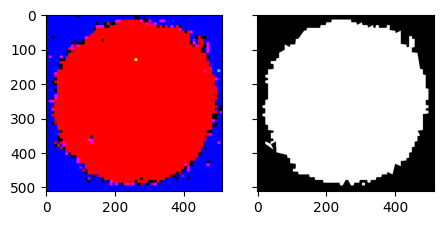

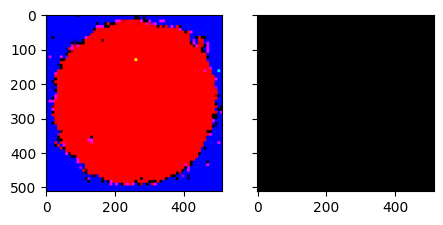

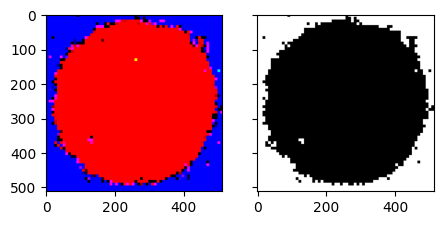

In [471]:
#red_cnts,imageSize=redContour([50,255,255],[0,80,80],'images/prueba.png',0.0500)
#green_cnts,_ =greenContour([90, 255,255],[36, 100, 0],'images/prueba.png',0.0500)
#border_cnts,_ =blueContour([255,255,255],[100,20,20],'images/prueba.png',0.0500)
resizeImage()
red_cnts,imageSize=redContour([50,255,255],[0,80,80],'images/generated_image_512.png',0.0018)
green_cnts,_ =greenContour([90, 255,255],[36, 100, 0],'images/generated_image_512.png',0.0020)
border_cnts,_ =blueContour([255,255,255],[120,20,20],'images/generated_image_512.png',0.0020)

## Dxf generation

In [374]:
dwg = ezdxf.new()#"AC1015"
msp = dwg.modelspace()

dwg.layers.new(name="conductor", dxfattribs={"color": 1})
dwg.layers.new(name="dielectric", dxfattribs={"color": 8})
dwg.layers.new(name="substrate", dxfattribs={"color": 5})

"""
Warning! This is the drwaing unit, not the HFSS original units.
To preserve the resolution everything needs to be rescaled and resized 
if image size is 512x512 it means 512 nm or 512 mm dpending on the units declared in dxf file
thus all drawing sizes must be scaled to fit.

working units together with multipliers must be chosen based on the need to keep ratio and size as we import from HFSS
"""
units="nm"
GoalSize=500
currentSize=imageSize[0] #assumming an squared image same witdth and height
multiplier=0
layerscale=0

if units=="mm":
    multiplier=0.1
    layerscale=1
elif units=="nm":
    multiplier=10
    layerscale=1000
else:
    pass


"""Here the original layers were given in mm
as the target units are nm, layers must be rescaled
"""

layers= {
         "conductor":{
             "thickness":0.01*layerscale,
             "material":"pec",
             "color": "red",
             "zpos":1.75*layerscale
         },
         "dielectric":{
             "thickness":0.8*layerscale,
             "material":"PTFE",
             "color": "green",
             "zpos":1.75*layerscale

         } ,
         "substrate":{
             "thickness":1.75*layerscale,
             "material":"Rogers RT/duroid 5880 (tm)",
             "color": "blue",
             "zpos":0

         }
    }



scale=multiplier*GoalSize/currentSize

red_squeezed = [np.squeeze(cnt, axis=1) for cnt in red_cnts]
inverted_red_squeezed = [scale*arr * [1, -1] for arr in red_squeezed]#*0.1

green_squeezed = [np.squeeze(cnt, axis=1) for cnt in green_cnts]
inverted_green_squeezed = [scale*arr * [1, -1] for arr in green_squeezed]#*0.1

border_squeezed = [np.squeeze(cnt, axis=1) for cnt in border_cnts]
inverted_border_squeezed = [scale*arr * [1, -1] for arr in border_squeezed]#*0.1



In [375]:
"""Select the layers to export"""
selectedLayer=["conductor", "substrate"]

for layer in selectedLayer:
    if layer=="conductor":

        for ctr in inverted_red_squeezed:
            line=msp.add_lwpolyline(
                ctr,
                format="xyb", close=True,
                dxfattribs={'layer': 'conductor'},
            )
            line.dxf.const_width = 0.5
    elif layer=="dielectric":

        for ctr in inverted_green_squeezed:
            line=msp.add_lwpolyline(
                ctr,
                format="xyb", close=True,
                dxfattribs={'layer': 'dielectric'},
            )
            line.dxf.const_width = 0.5
    elif layer=="substrate":

        for ctr in inverted_border_squeezed:
            line=msp.add_lwpolyline(
                ctr,
                format="xyb", close=True,
                dxfattribs={'layer': 'substrate'},
            )
            line.dxf.const_width = 0.5
    else:
        pass

    
    
    """To draw the outline """

#for ctr in inverted_red_squeezed:
#    for n in range(len(ctr)):
#        if n >= len(ctr) - 1:
#            n = 0
#            
#        try:
#            msp.add_line(ctr[n], ctr[n + 1], dxfattribs={"layer": "red", "lineweight": 30})
#        except IndexError:
#            pass



dwg.saveas("output.dxf")

## Elevation info

In [376]:

value=str([])

kwargs={
    "reports":"",
    "simulation_id":"simID",
   "variable_name":"variables",
    "value" : str([]),
    "units" : units,
   }
    
file = open('layers.tech', 'w')
file.write('units um \n')

print(layers)

for layer in layers:
    
    file.write(layer+" "+ layers[layer]["color"]+" "+ str(layers[layer]["zpos"]) +" "+ str(layers[layer]["thickness"]) +" "+'\n')

file.close()

{'conductor': {'thickness': 10.0, 'material': 'pec', 'color': 'red', 'zpos': 1750.0}, 'dielectric': {'thickness': 800.0, 'material': 'PTFE', 'color': 'green', 'zpos': 1750.0}, 'substrate': {'thickness': 1750.0, 'material': 'Rogers RT/duroid 5880 (tm)', 'color': 'blue', 'zpos': 0}}
